# Calculate Number of Devices within Areas of Interest

In this step, we calculate the number of devices detected within the **areas of interest**, creating a time series.

In [1]:
import dask.dataframe as dd
import geopandas
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import humanize
from dask.distributed import Client

In [2]:
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html
DASK_SCHEDULER_ADDRESS = None

AOI = "id=7&name=A"
NAME = "A"

In [3]:
client = Client(DASK_SCHEDULER_ADDRESS)

/Users/g4brielvs/.pyenv/versions/miniforge3/envs/datapartnership-syria-economic-monitor/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50029 instead
  warnings.warn(


## Data

### Area of Interest

In [4]:
AOI = geopandas.read_file(f"../../data/interim/aoi/{AOI}.geojson")

### Mobility Data

In this step, we import the panel of devices detected within the **area of interest**.

In [5]:
PATH = [
    f"../../data/interim/panels/{NAME}",
]

filters = []

Reading the mobility data as an [Apache Parquet Dataset](https://arrow.apache.org/docs/python/parquet.html) in parallel using [Dask](https://www.dask.org),

In [6]:
ddf = dd.read_parquet(PATH, filters=filters)

Filtering, 

In [7]:
ddf = ddf[ddf["h3_10"].isin(AOI["hex_id"])]

## Exploratory Data Analysis

First, let's just take a look!

In [8]:
# dropping uid, for privacy
ddf.head().drop(["uid"], axis="columns")

latitude  longitude            h3_10                  datetime  \
6934   34.637413  35.975620  8a2da225baeffff 2020-01-01 17:39:01+02:00   
24842  34.637543  35.976097  8a2da35a6db7fff 2020-01-02 17:54:28+02:00   
29011  34.664909  36.308998  8a2da348d807fff 2020-01-02 18:16:56+02:00   
29021  34.664909  36.308998  8a2da348d807fff 2020-01-02 18:01:56+02:00   
29022  34.664909  36.308998  8a2da348d807fff 2020-01-02 17:40:52+02:00   

            date country  year quarter  
6934  2020-01-01      LB  2020       1  
24842 2020-01-02      LB  2020       1  
29011 2020-01-02      LB  2020       1  
29021 2020-01-02      LB  2020       1  
29022 2020-01-02      LB  2020       1

In [9]:
humanize.naturalsize(ddf.memory_usage(deep=True).sum().compute())

'89.6 MB'

As seen, the data will easily fit in memory. Let's convert to a `pandas.DataFrame`.

In [10]:
df = ddf.compute()

In [11]:
len(df)

306785

And now, a sneak peek of 10,000 locations from the panel.

In [12]:
gdf = geopandas.GeoDataFrame(
    df[["longitude", "latitude"]].iloc[:10000],
    geometry=geopandas.points_from_xy(
        df.longitude.iloc[:10000], df.latitude.iloc[:10000], crs="EPSG:4326"
    ),
)
gdf.explore()

```{important}
This is a partial disclosure. Additional content in this section was suppressed from this notebook to adhere to the data classification policy.
```

## Generate Time Series 

Now, we are interested to see how the number of devices evolves in time. Let's calculate the daily number of devices detected withih the area of interest.

In [13]:
count = ddf.groupby(["date"])["uid"].nunique().compute().to_frame("count")

count.index = pd.to_datetime(count.index)

In [14]:
count.to_csv(f"../../data/interim/count/{NAME}.csv")

Plotting, 

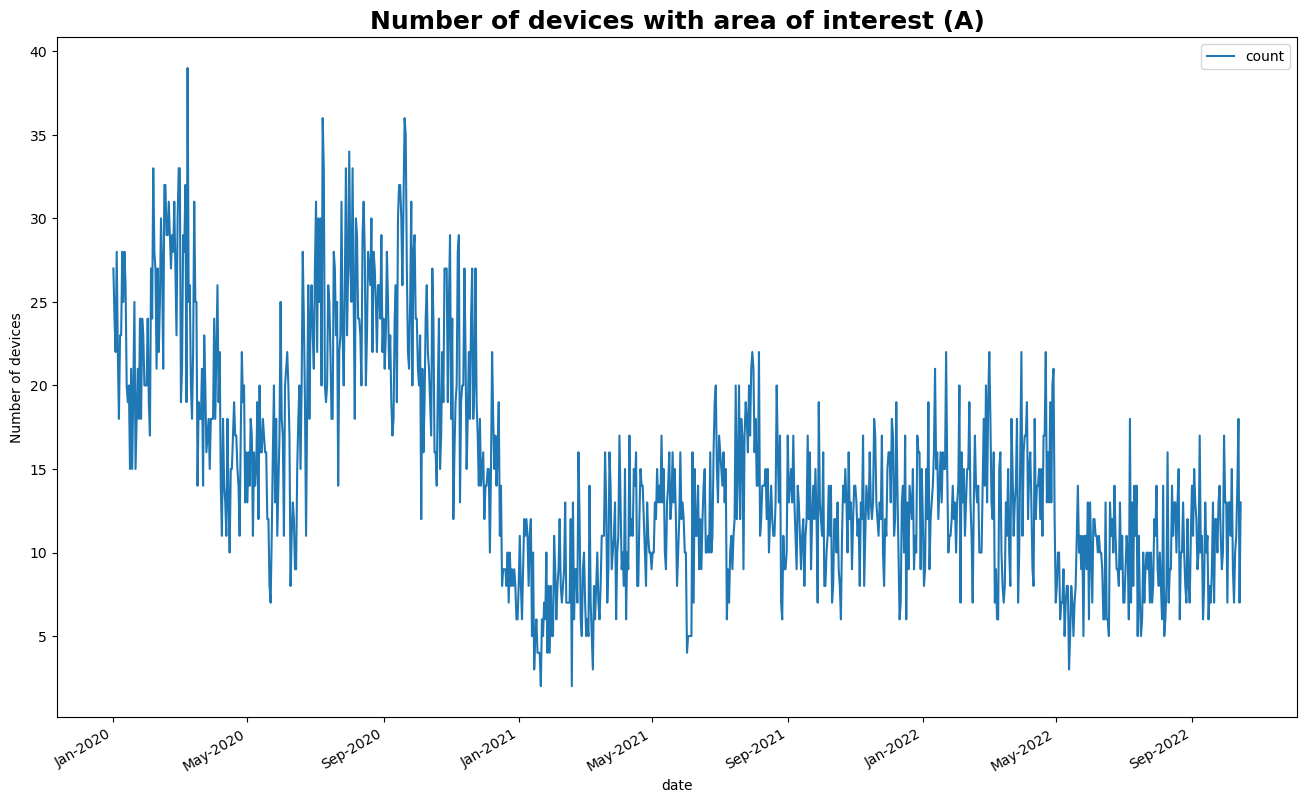

In [19]:
fig, ax = plt.subplots(figsize=(16, 10))

count.plot(ax=ax)
ax.set_title(
    f"Number of devices with area of interest ({NAME})",
    fontsize=18,
    fontweight="bold",
)
ax.yaxis.set_label_text("Number of devices")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"));

In [20]:
fig.savefig(
    f"../../reports/count_{NAME}.png", dpi=300, transparent=True, bbox_inches="tight"
)